# WIND TURBINE DATA ANALYSIS

This notebook aims at providing some useful guidelines for wind farm data analysis. The sample dataset used is provided by ENGIE Renewable Energy France and can be downloaded [HERE](https://opendata-renewables.engie.com/pages/home/).

The dataset refers to "La Haute Borne" windfarm located in Meuse, France. It is addressed as the first open data windfarm. It is made by 4 wind turbine generators. For sake of simplicity, this analysis take into account only one wind generator (R80711) and only historical data 2013-2016. The csv file can be downloaded [HERE](https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/export/?refine.wind_turbine_name=R80711).

## TABLE OF CONTENTS
* **Libraries** required for the following analysis
* **Data import** CSV file expected, but you can do whatever you want customizing one line of code
* **Data Cleaning and Preprocessing** useful tips to handle missing values and delete data sample that are not related to normal working conditions
* **Wind Turbine Performance Estimation**, calculating power output and capacity factor
* **Wind distribution analysis** thanks to windrose Python library
* **Build a simple power output prediction model** based only on external metereological data, using scikit-learn library

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import warnings
%matplotlib inline

## IMPORT DATA
Dataset format is expected to be a CSV fle containing all the features aquired from sensors placed inside and outside the wind generator. Data frequency is one sample every 10mins, which is a common situation for most of the wind turbine dara aqisition systems (generally, a SCADA system). Most literature studies about data-driven analysis of wind farms rely on this specific kind of dataset. this is why I chose it as a sample dataset and I warmly suggest you to do the same as far as your goal is to learn how to del with this kind of data.

Plese notice that you can try and import very different datasets with very different aquisition frequencies or number of acquired features. Most of the following analysis will help you find out some interesting trends in your data. If your find some other open datasets about wind farm, feel free to contact me and I'll make the code fit the new open sources.

In [2]:
cwd = os.getcwd()
data_wd = cwd + '/data/la-haute-borne-data-2013-2016.csv'
data = pd.read_csv(data_wd,sep=';')

In [3]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2013-01-06T11:20:00+01:00,-0.76,-1.0,0.00,0.40,13.78,13.0,14.0,0.35,...,NaN,NaN,293.01001,NaN,NaN,NaN,293.87,NaN,NaN,NaN
1,R80711,2013-01-06T07:30:00+01:00,-0.39,-1.0,0.07,0.35,13.00,13.0,13.0,0.00,...,NaN,NaN,263.41998,NaN,NaN,NaN,223.98,NaN,NaN,NaN
2,R80711,2013-01-06T14:00:00+01:00,-0.95,-1.0,0.00,0.17,14.00,14.0,14.0,0.00,...,NaN,NaN,305.81000,NaN,NaN,NaN,293.87,NaN,NaN,NaN
3,R80711,2013-01-06T09:50:00+01:00,-1.00,-1.0,-1.00,0.00,13.15,13.0,14.0,0.27,...,NaN,NaN,285.79999,NaN,NaN,NaN,293.87,NaN,NaN,NaN
4,R80711,2013-01-10T17:30:00+01:00,-1.00,-1.0,-1.00,0.00,9.56,9.0,10.0,0.42,...,NaN,NaN,201.86000,NaN,NaN,NaN,207.17,NaN,NaN,NaN


## PART I: DATA CLEANING AND PREPROCESSING
Data always needs cleaning, this is a fact. Nevertheless, data from an industrial piece of equipment like a turbine, a compressor a wind generator, ecc... require MORE cleaning from your side. Domain knowledge as well as programming skills are required to manipulate this kind of data.

The following section aims at:
1. Create new features that will be useful for the performance assessment task
2. Handle missing values, removing features wth too many NaN to be kept in the analysis or deleting rows containing NaNs from other features that will be kept
3. Flter and remove sample that belong to strange/unreliable operatng conditions, as well as shutdown/startup processes, ecc... To better estimate performance, this step is essential

### CALENDAR FEATURES CREATION

In [5]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.sort_values(by=['Date_time'], inplace=True, ascending=True)

data['Year'] = data['Date_time'].dt.year
data['Month'] = data['Date_time'].dt.month

In [6]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std,Year,Month
204352,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,180.25000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
106,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,183.28999,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
197382,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,185.08000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
102,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,190.33000,NaN,NaN,NaN,188.41000,NaN,NaN,NaN,2012,12
87893,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,188.07001,NaN,NaN,NaN,192.89999,NaN,NaN,NaN,2012,12


### MISSING VALUES TREATMENT
Plot of missing value count for each column of the dataframe. Columns with a number of missing values above a critical limit will be dropped. Columns with a reasonable number of NaN will be kept. Every row with one or more missing value will be dropped. For this analysis, it is not strictly mandatory to keep all the available features, yet for more sophisticated analysis there is a subtle trade-off:
* keep a large number of sample, dropping most of the features with the largest number of NaN
* keep as many features as you can, so that you don't lose pieces of information. In this case, you accept to lose more data samples, since more rows will be affected by NaN.

The replacement of NaN values with other values, such as average/median or other statistical approaches, is not recommended in this case. If you are going to build a physical models, or even a machine learning model with the aim of describing a physical sistem like a WTG, it is better to avoid heavy manipulation procedures. The identification of patterns of features can be negatively affected in this case. Better to lose weak data sample than add in your analysis unphysical data samples.

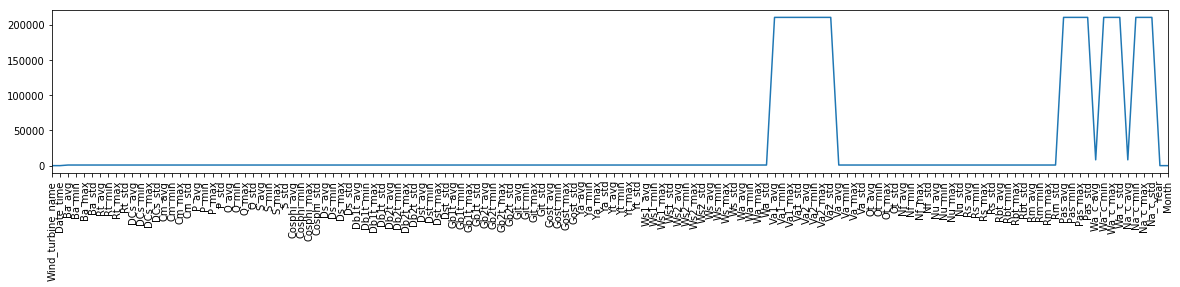

In [7]:
plt.figure(figsize=(20,3))
plt.plot(data.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [9]:
print('List of columns deleted because of NaN count exceeds maximum threshold')
print(list(data.loc[:,data.isnull().sum(axis = 0) > 10000].columns))
df = data.loc[:,data.isnull().sum(axis = 0) < 10000]

List of columns deleted because of NaN count exceeds maximum threshold
['Va1_avg', 'Va1_min', 'Va1_max', 'Va1_std', 'Va2_avg', 'Va2_min', 'Va2_max', 'Va2_std', 'Pas_avg', 'Pas_min', 'Pas_max', 'Pas_std', 'Wa_c_min', 'Wa_c_max', 'Wa_c_std', 'Na_c_min', 'Na_c_max', 'Na_c_std']


In [10]:
df.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Wa_c_avg,Na_c_avg,Year,Month
204352,R80711,2012-12-31 23:00:00,-1.00,-1.0,-1.0,0.0,12.76,12.0,13.0,0.36,...,28.799999,0.03,5690.2798,4037.4900,7382.7202,612.64001,180.25000,176.44000,2012,12
106,R80711,2012-12-31 23:10:00,-1.00,-1.0,-1.0,0.0,12.71,12.0,13.0,0.38,...,28.750000,0.01,5632.7202,3579.1001,7386.1099,746.62000,183.28999,176.44000,2012,12
197382,R80711,2012-12-31 23:20:00,-1.00,-1.0,-1.0,0.0,12.81,12.0,13.0,0.31,...,28.799999,0.03,6071.6899,4231.8799,8059.7798,853.60999,185.08000,176.44000,2012,12
102,R80711,2012-12-31 23:30:00,-1.00,-1.0,-1.0,0.0,12.70,12.0,13.0,0.38,...,29.000000,0.07,6279.4702,4090.2900,8978.8799,1022.31000,190.33000,188.41000,2012,12
87893,R80711,2012-12-31 23:40:00,-0.98,-1.0,-0.5,0.1,12.40,12.0,13.0,0.41,...,28.900000,0.05,6988.5698,4366.8901,9823.5400,1135.03000,188.07001,192.89999,2012,12


In [11]:
df.shape[0]

210095

In [12]:
df_no_na = df.dropna()
df_no_na.shape[0]

201867

### FILTERING IDLE/SHUTDOWN/STARTUP

Any model or statistical analysis you want to build must keep into account normal-condition operating data. In our case, it is not correct to include samples referred to operating conditions far from the normal working range of a wind turbine. A simple way to filter unuseful data samples is proposed, base on three main features:
* Power Output (kW). It must be above 0 kW and below the maximum rated power (in this example 2050kW). Check on manufacturer specifics to get the correct nominal power. It seems obvious, but it is common to find unphysical values of power output that can have a huge impact on your analysis.
* Wind Speed (m/s). In this notebook we are going to evaluate turbine performance. Hence, we need to exclude all those points that don't bring actual power output. For this reason, too low wind speed (cut in limit) and too high wind speed (cut off limit) must be excluded.
* Pitch angle (°). Pitch angle is an indicator of the position of turbine blades with respect to wind direction. In  normal operating condition, this angle is very low and slightly negative (from -5° to - 0°). Values far from these limits refer to particular conditions that must be excluded from future analysis.

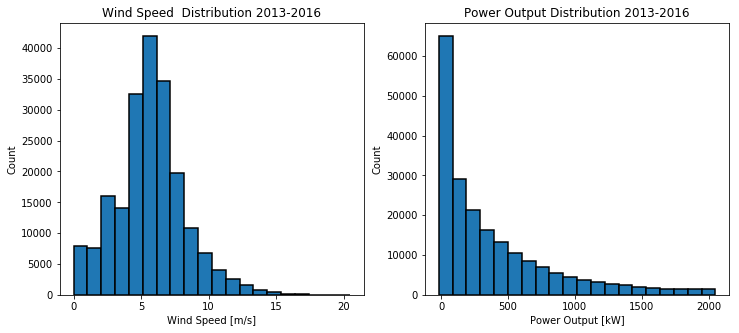

In [13]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ws_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Wind Speed  Distribution 2013-2016')
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Count')
ax2.hist(df_no_na['P_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Power Output Distribution 2013-2016')
ax2.set_xlabel('Power Output [kW]')
ax2.set_ylabel('Count')

plt.show()

In [14]:
df_clean = df_no_na[df_no_na['Ws_avg']>3]
df_clean = df_clean[df_clean['Ws_avg'] < 25]
df_clean = df_clean[df_clean['Ba_avg'] < 5]
df_clean = df_clean[df_clean['Ba_avg'] > -5]
df_clean.shape[0]

159329

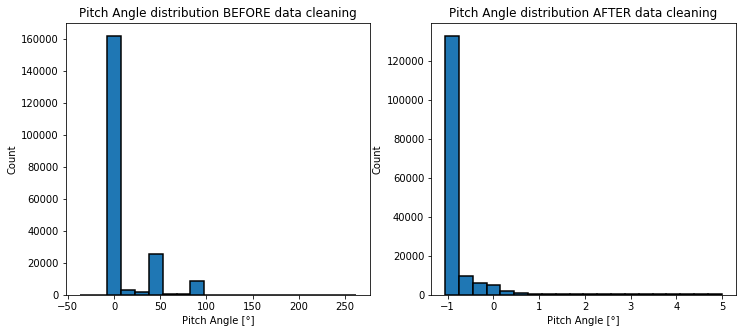

In [15]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Pitch Angle distribution BEFORE data cleaning')
ax1.set_xlabel('Pitch Angle [°]')
ax1.set_ylabel('Count')
ax2.hist(df_clean['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Pitch Angle distribution AFTER data cleaning')
ax2.set_xlabel('Pitch Angle [°]')
ax2.set_ylabel('Count')

plt.show()

# PART II: WIND TURBINE PERFORMANCE ESTIMATION

Two ways of WTG (Wind Turbine Generator) performance estimation are considered:
1. Power Output calculation (on a mothly basis for an annual comparison)
2. Capacity Factor estimation, so that we can compare this specific turbine with other turbines or power production technologies using a dimensionless parameter. 

## POWER OUTPUT CALCULATION

In [16]:
df_clean['E_avg'] = df_clean['P_avg'] / 6000 # from kW to MWh
df_energy = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
df_energy.reset_index(inplace=True)

In [17]:
df_energy_boxplot = df_energy[df_energy.E_avg > 10]

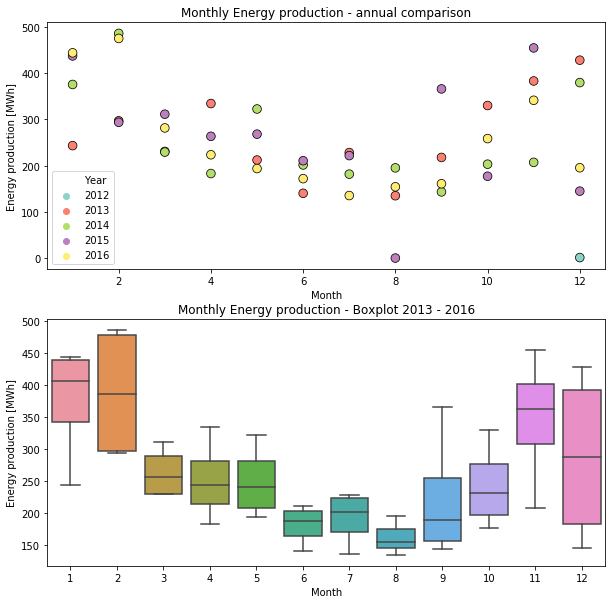

In [18]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="E_avg", hue = 'Year', data=df_energy, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black',legend='full')
ax1.set_title('Monthly Energy production - annual comparison')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy production [MWh]')

sns.catplot(x="Month", y="E_avg", kind="box", data=df_energy_boxplot, ax = ax2)
ax2.set_title('Monthly Energy production - Boxplot 2013 - 2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('Energy production [MWh]')

plt.close(2)

## CAPACITY FACTORY ESTIMATION

**Capacity Factor** is a design parameter. In absolute value it does not gives us information about WTG performance. It is computed as the ratio between real power output and nominal rated power (2050 kW in this sample case):

$CF = \frac{P_{real}}{P_{rated}}$

For a wind turbine generator, the usual CF ranges between 20% and 40%, depending on several design choices made by the manufactures and plant owner:
1. Number of WTG installed in the farm
2. Wind availability and annual distribution for that specific location
3. WTG technology

Nevertheless, CF can be a good indicator of WTG performance as a relative comparison. For instance, one can:
1. compare WTGs in the very same farm and with the same technical specs and assess the impact of wake effects
2. compare data from the very same WTG (as we are gonna do in a while) and look at the difference between different years of months

In [19]:
P_nom = 2050 # kW | nominal power
df_clean['Cf_avg'] = df_clean['P_avg'] / P_nom # from kW to CF
df_cf = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['Cf_avg'].apply(lambda x : x.mean()))
df_cf.reset_index(inplace=True)

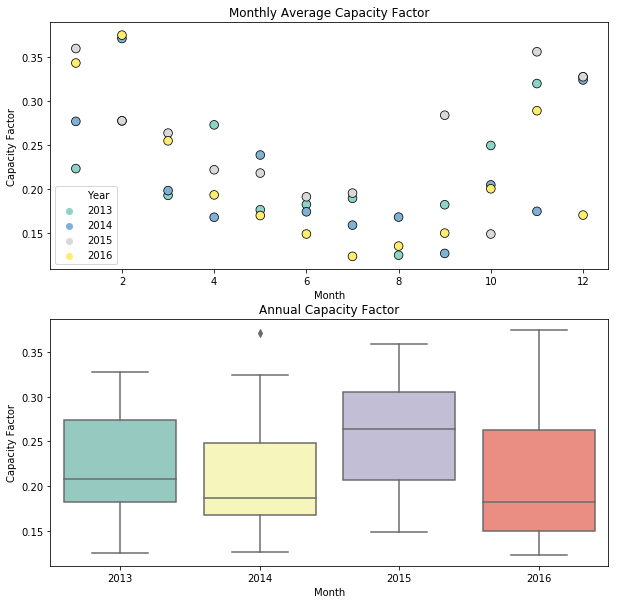

In [20]:
df_cf_boxplot = df_cf[(df_cf.Cf_avg > 0.05) & (df_cf.Cf_avg < 0.5)]

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="Cf_avg", hue = 'Year', data=df_cf_boxplot, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black')
ax1.set_title('Monthly Average Capacity Factor')
ax1.set_xlabel('Month')
ax1.set_ylabel('Capacity Factor')

sns.catplot(x="Year", y="Cf_avg", kind = 'box', data=df_cf_boxplot, ax = ax2, palette = "Set3")
ax2.set_title('Annual Capacity Factor')
ax2.set_xlabel('Month')
ax2.set_ylabel('Capacity Factor')

plt.close(2)

# PART III: WIND DISTRIBUTION ANALYSIS USING WINDROSE LIBRARY

[windrose Python library]() is a wonderful resource for those who want to easily plot wind data in one line of code. Moreover, this library is perfectly integrated with NumPy and Matplotlib, so customization possibilities are limitless.

Using this library, the following analysis aims at 
1. understanding if there have been significant changes in wind availability during the year (seasonality effects) 
2. comparing historical data for an annual comparison (period 2013-2016)
### WINDROSE ANALYSIS: ANNUAL COMPARISON

/home/matteo/Documents/py36/lib/python3.6/site-packages/windrose/windrose.py:457: MatplotlibDeprecationWarning: The poly_between function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  xs, ys = poly_between(angles, 0, val)


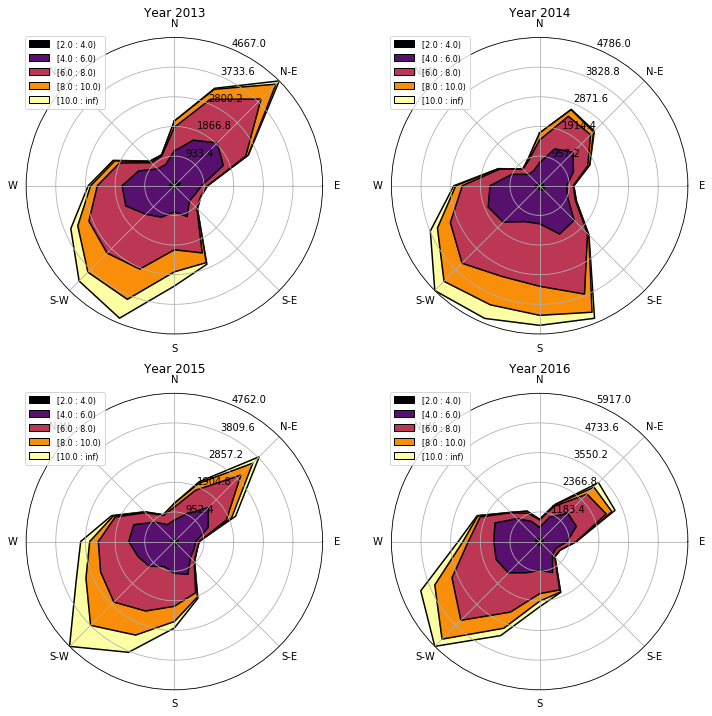

In [21]:
warnings.filterwarnings(action='once')
f = plt.figure(figsize=(12,12))
leg_pos = 'upper left'

ax1 = f.add_subplot(221,projection='windrose')
ax1.set_title('Year 2013')
anno=2013

ax1.contourf(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax1.contour(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax1.set_legend(loc=leg_pos)

ax2 = f.add_subplot(222,projection='windrose')
ax2.set_title('Year 2014')
anno=2014

ax2.contourf(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax2.contour(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax2.set_legend(loc=leg_pos)

ax3 = f.add_subplot(223,projection='windrose')
ax3.set_title('Year 2015')
anno=2015

ax3.contourf(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax3.contour(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax3.set_legend(loc=leg_pos)

ax4 = f.add_subplot(224,projection='windrose')
ax4.set_title('Year 2016')
anno=2016

ax4.contourf(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax4.contour(df_clean.loc[df_clean['Year']==anno,'Wa_c_avg'], df_clean.loc[df_clean['Year']==anno,'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax4.set_legend(loc=leg_pos)

plt.show()

**Comment** Annual windrose comparison does not show a significant difference in terms of wind intensity and direction among years. Only 2014 seems to show a different wind direction pattern, with a double prevalent direction (SW and S) compared to the remaining years (only S). 

This is consistent with many literature finding and generally speaking with many Southern and Central Europe locations. Wind is available in one dominant direction, if we look at the average annual behavior.

### WINDROSE ANALYSIS: SEASONAL COMPARISON

/home/matteo/Documents/py36/lib/python3.6/site-packages/windrose/windrose.py:457: MatplotlibDeprecationWarning: The poly_between function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  xs, ys = poly_between(angles, 0, val)


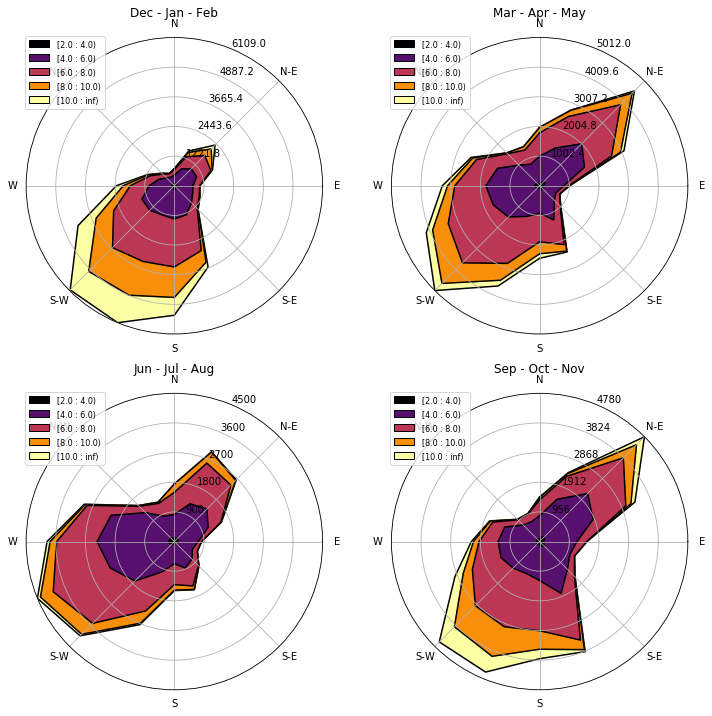

In [22]:
warnings.filterwarnings(action='once')
f = plt.figure(figsize=(12,12))
leg_pos = 'upper left'

ax1 = f.add_subplot(221,projection='windrose')
ax1.set_title('Dec - Jan - Feb')
mese = [12,1,2]


ax1.contourf(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax1.contour(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax1.set_legend(loc=leg_pos)

ax2 = f.add_subplot(222,projection='windrose')
ax2.set_title('Mar - Apr - May')
mese = [3,4,5]

ax2.contourf(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax2.contour(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax2.set_legend(loc=leg_pos)

ax3 = f.add_subplot(223,projection='windrose')
ax3.set_title('Jun - Jul - Aug')
mese = [6,7,8]

ax3.contourf(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax3.contour(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax3.set_legend(loc=leg_pos)

ax4 = f.add_subplot(224,projection='windrose')
ax4.set_title('Sep - Oct - Nov')
mese = [9,10,11]

ax4.contourf(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'], 
             bins = np.arange(2, 12, 2),cmap=cm.inferno)
ax4.contour(df_clean.loc[df_clean['Month'].isin(mese),'Wa_c_avg'], df_clean.loc[df_clean['Month'].isin(mese),'Ws_avg'],
            colors='black',bins = np.arange(2, 12, 2))
ax4.set_legend(loc=leg_pos)

plt.show()

**Comment** Compared to the previous windrose diagram, we can clearly distinguish season effects during the observed perios (2013-2016). Dominant wind direction is always the same (mostly NE-SW), but in some periods (Spring and Fall) it tends to be balanced in orientation, while in Winter and Summer the wind blows from NE to SW, and not the opposite.

Moreover, this diagrams proves the behaviour of Power Output and Capacity factor curves showed before: Winter and Fall charts hightlight a stronger wind intensity (lighter region with wind above 10 m/s) compared to Summer and Spring ones.